In [1]:
#main libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#vectorizors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [3]:
#store values in pickles 
from sklearn.externals import joblib

In [4]:
#performence metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [5]:
#modules for building ML model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

## Objective

1. Train, CV, Test split.

2. find right 'c' (1/Lambda), gamma(1/sigma) using gridsearchcv(), randomsearchcv().

3. Build SVC with featurisation techniques like BOW, TFIDF AVGW2V2 TFIDFW2V and use l1 or l2 regularizor.

4. get accuracy, precision scores, confusion matrrix, recall score, f1 score.

In [8]:
#connect sql database
con = sqlite3.connect('final.sqlite')

In [9]:
#read sql data using pandas
data = pd.read_sql("SELECT * FROM REVIEWS", con)

In [10]:
def partition(x) :
    if x == 'positive' :
        return 1
    return 0

actualscore = data['Score']
positivenegative = actualscore.map(partition)
data['Score'] = positivenegative

In [11]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


Number of positive & negative data points are 
 1    307061
0     57110
Name: Score, dtype: int64


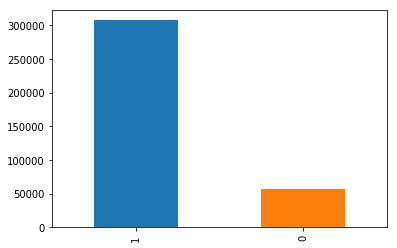

In [12]:
print ('Number of positive & negative data points are \n',data['Score'].value_counts())
data['Score'].value_counts().plot(kind='bar')

In [13]:
#sort data based on time
df_time_sorted = data.sort_values('Time', kind ='quicksort')

In [14]:
df_time_sorted.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


The important piece of information from dataset for building ML models are text reviews and their Scores if they are positive or negative so lets seperate only those two columns into a seperate dataframe using pandas

In [15]:
df = pd.DataFrame(data, columns=['CleanedText', 'Score'])
df.head()

,CleanedText,Score
0,witti littl book make son laugh loud recit car...,1
1,grew read sendak book watch realli rosi movi i...,1
2,fun way children learn month year learn poem t...,1
3,great littl book read nice rhythm well good re...,1
4,book poetri month year goe month cute littl po...,1


In [16]:
#lets check the total dataset values
df.shape

(364171, 2)

Number of +ve & -ve datapoints 
 1    307061
0     57110
Name: Score, dtype: int64


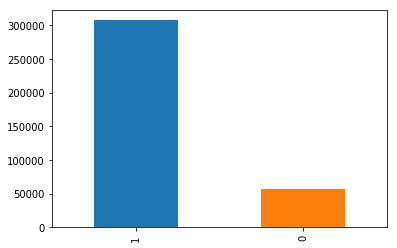

In [15]:
df_sample = df
print ('Number of +ve & -ve datapoints \n' ,df_sample['Score'].value_counts())
df_sample['Score'].value_counts().plot(kind='bar')

In [16]:
X = df_sample['CleanedText']
y = df_sample['Score']
print (X.shape)
print (y.shape)

(364171,)
(364171,)


In [17]:
#test-train-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)
print('X_train shape :' ,X_train.shape)
print('y_train shape :' ,y_train.shape)
print('X_test shape :' ,X_test.shape)
print('y_test shape :' ,y_test.shape)

X_train shape : (254919,)
y_train shape : (254919,)
X_test shape : (109252,)
y_test shape : (109252,)


In [18]:
joblib.dump(X_train, 'X_train.pkl') 
joblib.dump(X_test, 'X_test.pkl') 
joblib.dump(X_train, 'y_train.pkl') 
joblib.dump(X_test, 'y_test.pkl') 

['y_test.pkl']

In [19]:
X_train = joblib.load('X_train.pkl') 
X_test = joblib.load('X_test.pkl') 
y_train = joblib.load('y_train.pkl') 
y_test = joblib.load('y_test.pkl') 

### check if rows are not shuffled since its time series data

In [18]:
X_train.head()

0    witti littl book make son laugh loud recit car...
1    grew read sendak book watch realli rosi movi i...
2    fun way children learn month year learn poem t...
3    great littl book read nice rhythm well good re...
4    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

In [19]:
X_test.head()

254919    word want reduc caffienn brand best choic use ...
254920    louisiana nativ like peopl louisiana drink com...
254921    drink number brand coffe definit dont enjoy fi...
254922    purchas great price amazon pleas flavor buddi ...
254923    love coffe still block form fresh communiti co...
Name: CleanedText, dtype: object

In [20]:
X_train.tail()

254914       havent found decaff serv challah one give rebb
254915    purchas coffe base posit feedback either got b...
254916    drank communiti coffe mani year recent becam c...
254917    bought pack give other kept one tri glad great...
254918    love communiti coffe yummi strong without grea...
Name: CleanedText, dtype: object

In [21]:
X_test.tail()

364166    love love sweeten use bake unsweeten flavor co...
364167    tri sauc believ start littl sweet honey tast b...
364168    bought hazelnut past nocciola spread local sho...
364169    purchas product local store kid love quick eas...
364170    purchas send son whos away colleg deliv right ...
Name: CleanedText, dtype: object

**Since SVM is Computationally expensive and very time consuming. and specifically GridSearch takes a lot of time for SVC(). so, we use**
- SGDClassifier with hinge loss along with GridSearchCV & RandomizedSearchCV

# Functions to find Hyperparameter & Use Logistic Regression

In [22]:
def SGD_best_params (X_train, y_train) :
    #c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
    #gamma = 1/sigma, sigma = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
    clf = SGDClassifier(loss='hinge')
    cv= TimeSeriesSplit(n_splits=10)
    param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 
                  'penalty':['l1','l2', 'elasticnet']}
    grid_cv = GridSearchCV(clf, param_grid, cv=cv, verbose=1, n_jobs=-1)
    grid_cv.fit(X_train,y_train)
    print("Best HyperParameter: ",grid_cv.best_params_)
    print("Best Accuracy: ", (grid_cv.best_score_*100))
    #accessing cv_results
    cv_results = pd.DataFrame(grid_cv.cv_results_)
    alpha_cv = cv_results[['param_alpha', 'mean_test_score']]
    plot_data = alpha_cv.loc[::3, :]
    #Function for cv_error vs alpha plot
    plt.figure(figsize=(10,6))
    plt.xlabel('Alpha')
    plt.ylabel('Best Score')
    plt.plot(plot_data['param_alpha'], plot_data['mean_test_score'], marker='o', markerfacecolor='green', markersize=10)

In [23]:
def SGD(alpha, penalty, X_train, y_train, X_test, y_test) :
    clf = SGDClassifier(alpha=alpha, penalty=penalty, loss='hinge')
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print('accuracy_score =', accuracy_score(y_test, y_pred))
    print('precision_score =', precision_score(y_test, y_pred))
    print('recall_score =', recall_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    return y_pred

In [49]:
#c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
def SGD_best_params_rand (X_train, y_train) :
    clf = SGDClassifier(loss='hinge')
    cv= TimeSeriesSplit(n_splits=10)
    #param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
    param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 
              'penalty':['l1','l2', 'elasticnet']}
    rand_cv = RandomizedSearchCV(clf, param_grid, cv=cv, verbose=1, n_jobs=-1, random_state=42)
    rand_cv.fit(X_train,y_train)
    print("Best HyperParameter: ",rand_cv.best_params_)
    print("Best Accuracy: ", (rand_cv.best_score_*100))  
    #accessing cv_results
    cv_results = pd.DataFrame(rand_cv.cv_results_)
    alpha_cv = cv_results[['param_alpha', 'mean_test_score']]
    plot_data = alpha_cv.sort_values('param_alpha')
    #Function for cv_error vs alpha plot
    plt.figure(figsize=(10,6))
    plt.xlabel('Alpha')
    plt.ylabel('Best Score')
    plt.plot(plot_data['param_alpha'], plot_data['mean_test_score'], marker='o', markerfacecolor='green', markersize=10)

In [25]:
def SGD_rand(alpha, penalty, X_train, y_train, X_test, y_test) :
    #clf = SVC(C=C , gamma=gamma )
    clf = SGDClassifier(alpha=alpha, penalty=penalty, loss='hinge')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('accuracy_score =', accuracy_score(y_test, y_pred))
    print('precision_score =', precision_score(y_test, y_pred))
    print('recall_score =', recall_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    return y_pred

# BAG of WORDS

In [54]:
vect = CountVectorizer()

In [55]:
bow_X_train = vect.fit_transform(X_train)
bow_X_train = preprocessing.normalize(bow_X_train)
bow_X_train

<254919x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 7863068 stored elements in Compressed Sparse Row format>

In [56]:
bow_X_test = vect.transform(X_test)
bow_X_test = preprocessing.normalize(bow_X_test)
bow_X_test

<109252x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 3581565 stored elements in Compressed Sparse Row format>

In [57]:
joblib.dump(bow_X_train, 'bow_X_train.pkl') 
joblib.dump(bow_X_test, 'bow_X_test.pkl') 

['bow_X_test.pkl']

In [58]:
bow_X_train = joblib.load('bow_X_train.pkl') 
bow_X_test = joblib.load('bow_X_test.pkl') 

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.5min finished


Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy:  90.57305601104686


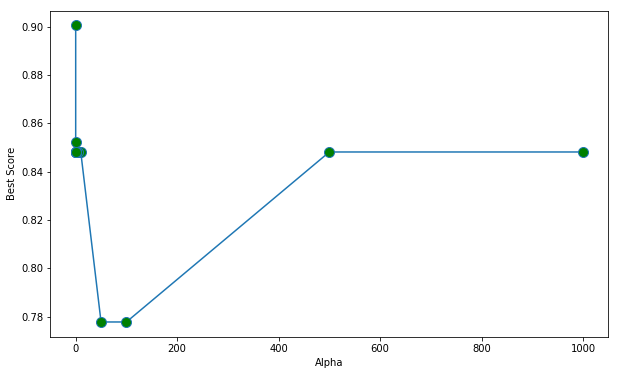

In [29]:
SGD_best_params(bow_X_train, y_train)

accuracy_score = 0.9013839563577783
precision_score = 0.9016603834122082
recall_score = 0.9893722357911413
Wall time: 528 ms


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

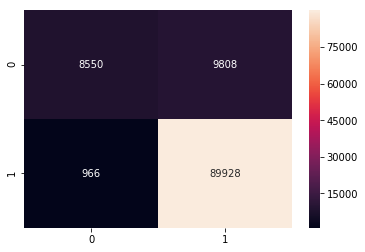

In [30]:
%time SGD(0.0001, 'l2', bow_X_train, y_train, bow_X_test, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.2s finished


Best HyperParameter:  {'penalty': 'l2', 'alpha': 0.0001}
Best Accuracy:  90.59894709588332


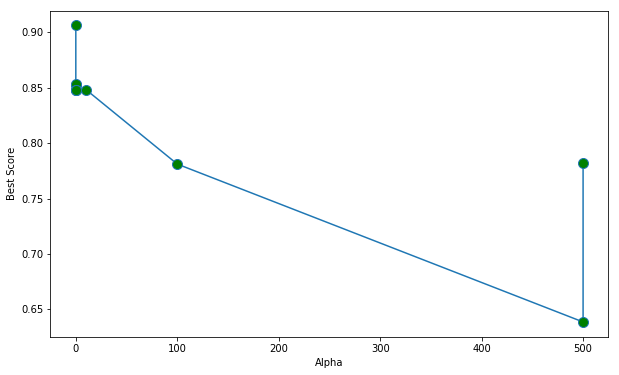

In [59]:
SGD_best_params_rand(bow_X_train, y_train)

accuracy_score = 0.9008256141763995
precision_score = 0.9007638937556942
recall_score = 0.9898453143221775


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

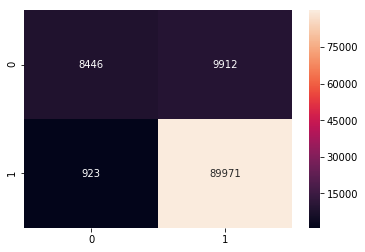

In [32]:
SGD_rand(0.0001,'l2', bow_X_train, y_train, bow_X_test, y_test)

# TFIDF

In [33]:
vect = TfidfVectorizer()

In [34]:
from sklearn import preprocessing
tfidf_X_train = vect.fit_transform(X_train)
tfidf_X_train = preprocessing.normalize(tfidf_X_train)
tfidf_X_train

<254919x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 7863068 stored elements in Compressed Sparse Row format>

In [35]:
tfidf_X_test = vect.transform(X_test)
tfidf_X_test = preprocessing.normalize(tfidf_X_test)
tfidf_X_test

<109252x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 3581565 stored elements in Compressed Sparse Row format>

In [ ]:
joblib.dump(tfidf_X_train, 'tfidf_X_train.pkl') 
joblib.dump(tfidf_X_test, 'tfidf_X_test.pkl') 

In [ ]:
tfidf_X_train = joblib.load(tfidf_X_train, 'tfidf_X_train.pkl') 
tfidf_X_test = joblib.load(tfidf_X_test, 'tfidf_X_test.pkl') 

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.4min finished


Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy:  90.53378786571157


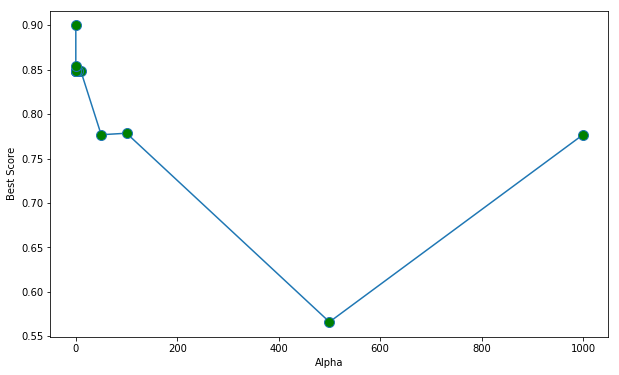

In [36]:
SGD_best_params(tfidf_X_train, y_train)

accuracy_score = 0.8994984073518105
precision_score = 0.8979226004342024
recall_score = 0.9919686667986886


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

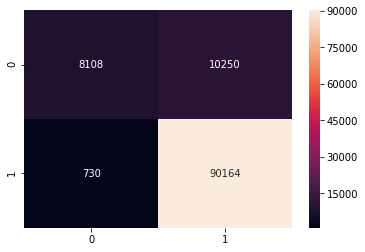

In [37]:
SGD(0.0001, 'l2', tfidf_X_train, y_train, tfidf_X_test, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.5s finished


Best HyperParameter:  {'penalty': 'l2', 'alpha': 0.0001}
Best Accuracy:  90.59074825235177


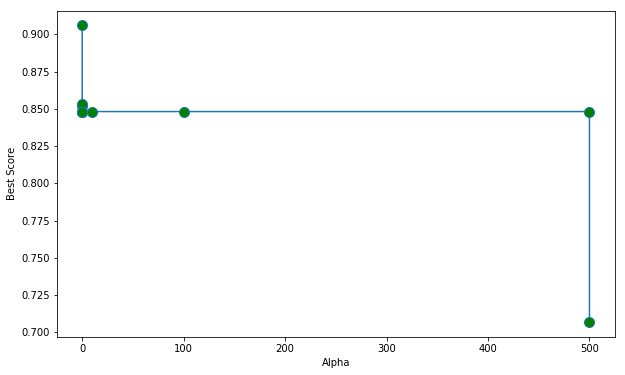

In [38]:
SGD_best_params_rand(tfidf_X_train, y_train)

accuracy_score = 0.8993794163951232
precision_score = 0.897774680141385
recall_score = 0.9920126741039013


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

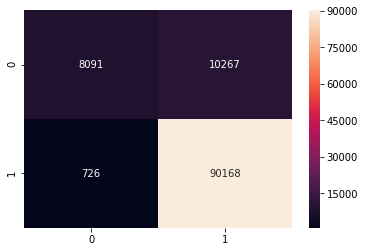

In [39]:
SGD_rand(0.0001,'l2', tfidf_X_train, y_train, tfidf_X_test, y_test)

# WORD2VECTOR Model

**AVGW2V & TFIDFW2V takes lot of time to train so we use only first 100k data**

Number of +ve & -ve datapoints 
 1    307061
0     57110
Name: Score, dtype: int64


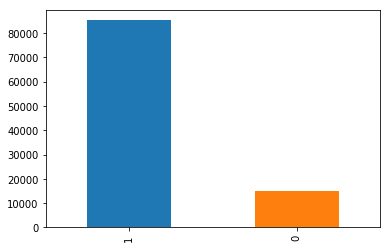

In [26]:
w2v_data = df.head(100000)
print ('Number of +ve & -ve datapoints \n' ,df_sample['Score'].value_counts())
w2v_data['Score'].value_counts().plot(kind='bar')

In [27]:
w2v_X = w2v_data['CleanedText']
w2v_y = w2v_data['Score']
print (w2v_X.shape)
print (w2v_y.shape)

(100000,)
(100000,)


In [28]:
#test-train-split
w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test = train_test_split(w2v_X, w2v_y, test_size=0.3,shuffle=False)
print('X_train shape :' ,w2v_X_train.shape)
print('y_train shape :' ,w2v_y_train.shape)
print('X_test shape :' ,w2v_X_test.shape)
print('y_test shape :' ,w2v_y_test.shape)

X_train shape : (70000,)
y_train shape : (70000,)
X_test shape : (30000,)
y_test shape : (30000,)


In [29]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in w2v_X_train.values:
    list_of_sent.append(sent.split())

In [30]:
print(w2v_X_train.values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [31]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [ ]:
joblib.dump(w2v, 'w2v.pkl')

In [ ]:
w2v_model = joblib.load(w2v, 'w2v.pkl')

In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10848
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand']


# AVGW2V

### AVGW2V on train data

In [44]:

# average Word2Vec
# compute average word2vec for each review.
%time train_vectors = []; # the avg-w2v for each sentence/review is stored in this li
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

Wall time: 0 ns
254919
50


In [45]:
avgw2v_train = preprocessing.normalize(train_vectors)

### AVGW2V on test data

In [39]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_in_test=[]
for sent in w2v_X_test.values:
    list_of_sent_in_test.append(sent.split())

In [40]:
print(w2v_X_test.values[0])
print("*****************************************************************")
print(list_of_sent_in_test[0])

introduc madhava agav sister back jan diabet run famili decid use tea coffe cereal cold hot pass friend famili found also enjoy benefit tast doesnt take much make thing sweet high recommend anyon children well amazon best price
*****************************************************************
['introduc', 'madhava', 'agav', 'sister', 'back', 'jan', 'diabet', 'run', 'famili', 'decid', 'use', 'tea', 'coffe', 'cereal', 'cold', 'hot', 'pass', 'friend', 'famili', 'found', 'also', 'enjoy', 'benefit', 'tast', 'doesnt', 'take', 'much', 'make', 'thing', 'sweet', 'high', 'recommend', 'anyon', 'children', 'well', 'amazon', 'best', 'price']


In [48]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent_in_test : # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

109252
50


In [49]:
avgw2v_test = preprocessing.normalize(test_vectors)

In [ ]:
joblib.dump(avgw2v_train, 'avgw2v_train.pkl') 
joblib.dump(avgw2v_test, 'avgw2v_test.pkl') 

In [ ]:
avgw2v_train = joblib.load('avgw2v_train.pkl') 
avgw2v_test = joblib.load('avgw2v_test.pkl') 

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.5min finished


Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy:  89.81703633382239


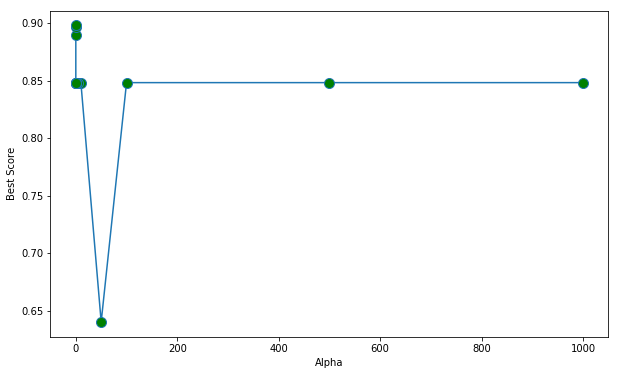

In [50]:
SGD_best_params(avgw2v_train, y_train)

accuracy_score = 0.8903086442353458
precision_score = 0.9058571810644558
recall_score = 0.968842827909433


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

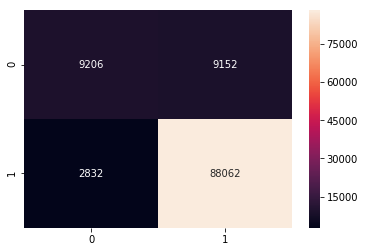

In [51]:
SGD(0.0001, 'l2', avgw2v_train, y_train, avgw2v_test, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.7s finished


Best HyperParameter:  {'penalty': 'l2', 'alpha': 0.0001}
Best Accuracy:  90.59506343315785


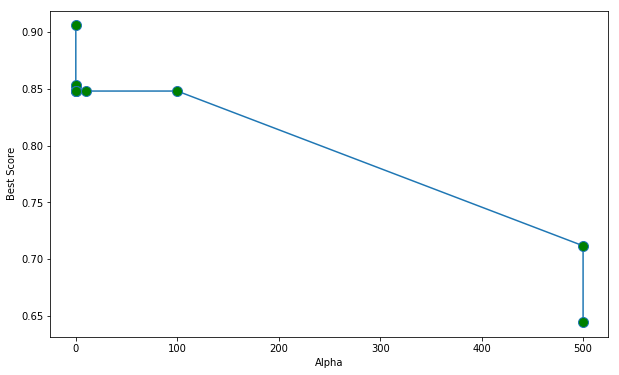

In [52]:
SGD_best_params_rand(avgw2v_train, y_train)

accuracy_score = 0.8867938344378135
precision_score = 0.8938430365525819
recall_score = 0.9803617400488481


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

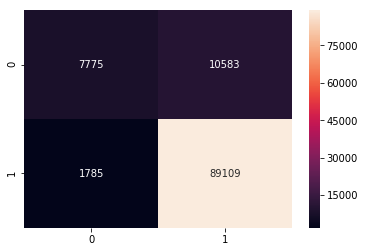

In [53]:
SGD_rand(0.0001,'l2', avgw2v_train, y_train, avgw2v_test, y_test)

# TFIDFW2V

### TFIDFW2V on Train data

In [33]:
#calculate TFIDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf_train = tf_idf_vect.fit_transform(w2v_X_train.values)
final_tf_idf_test = tf_idf_vect.transform(w2v_X_test.values)

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
print(len(tfidf_train_vectors))
print(len(tfidf_train_vectors[0]))

70000
50


In [44]:
tfidfw2v_train = preprocessing.normalize(tfidf_train_vectors)
#tfidfw2v_train = tfidf_train_vectors

### TFIDFW2V on Test Data

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_in_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
print(len(tfidf_test_vectors))
print(len(tfidf_test_vectors[0]))


30000
50


In [43]:
tfidfw2v_test = preprocessing.normalize(tfidf_test_vectors)
tfidfw2v_test.shape

(30000, 50)

In [ ]:
joblib.dump(tfidfw2v_train, 'tfidfw2v_train.pkl') 
joblib.dump(tfidfw2v_test, 'tfidfw2v_test.pkl') 

In [ ]:
tfidfw2v_train = joblib.load('tfidfw2v_train.pkl') 
tfidfw2v_test = joblib.load('tfidfw2v_test.pkl') 

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   32.4s finished


Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy:  87.82806852113782


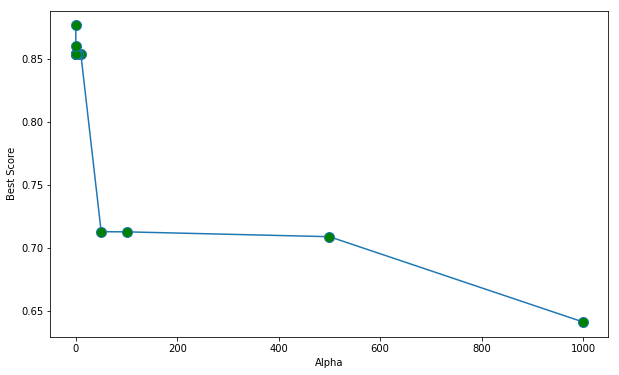

In [46]:
SGD_best_params(tfidfw2v_train, w2v_y_train)

accuracy_score = 0.8780333333333333
precision_score = 0.883320501154896
recall_score = 0.9872873068648543


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

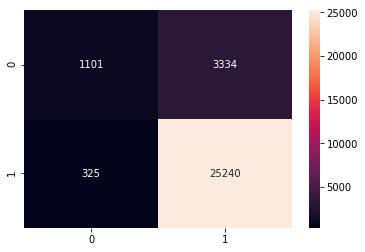

In [47]:
SGD(0.0001, 'l2', tfidfw2v_train, w2v_y_train, tfidfw2v_test, w2v_y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished


Best HyperParameter:  {'penalty': 'l2', 'alpha': 0.0001}
Best Accuracy:  87.78249253496779


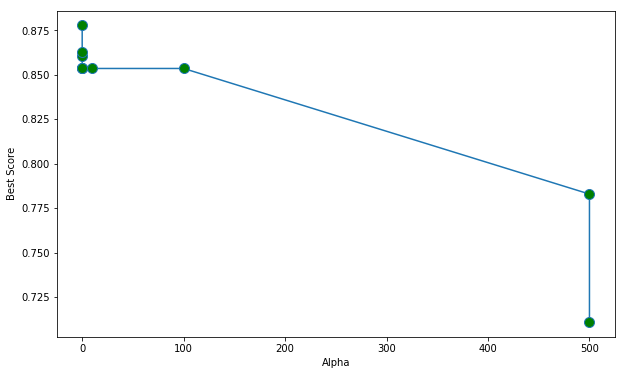

In [50]:
SGD_best_params_rand(tfidfw2v_train, w2v_y_train)

accuracy_score = 0.8765
precision_score = 0.8800417246175244
recall_score = 0.9900254253862703


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

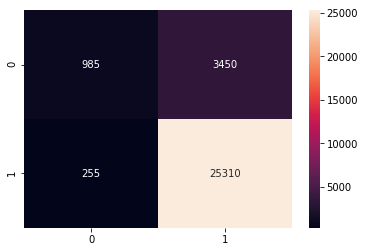

In [51]:
SGD_rand(0.0001,'l2', tfidfw2v_train, w2v_y_train, tfidfw2v_test, w2v_y_test)

# SVM WITH SKLEARN CLASSIFIER ON OUR BEST MODEL BOW

Number of +ve & -ve datapoints 
 1    85197
0    14803
Name: Score, dtype: int64


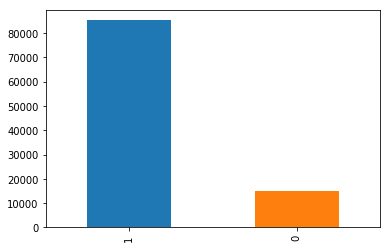

In [79]:
SVM_df_sample = df.head(100000)
print ('Number of +ve & -ve datapoints \n' ,SVM_df_sample['Score'].value_counts())
SVM_df_sample['Score'].value_counts().plot(kind='bar')

In [80]:
SVM_X = SVM_df_sample['CleanedText']
SVM_y = SVM_df_sample['Score']
print (SVM_X.shape)
print (SVM_y.shape)

(100000,)
(100000,)


In [81]:
#test-train-split
SVM_X_train, SVM_X_test, SVM_y_train, SVM_y_test = train_test_split(SVM_X, SVM_y, test_size=0.3,shuffle=False)
print('X_train shape :' ,SVM_X_train.shape)
print('y_train shape :' ,SVM_y_train.shape)
print('X_test shape :' ,SVM_X_test.shape)
print('y_test shape :' ,SVM_y_test.shape)

X_train shape : (70000,)
y_train shape : (70000,)
X_test shape : (30000,)
y_test shape : (30000,)


In [82]:
vect = CountVectorizer()

In [83]:
bow_X_train = vect.fit_transform(SVM_X_train)
bow_X_train = preprocessing.normalize(bow_X_train)
bow_X_train

<70000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 2162199 stored elements in Compressed Sparse Row format>

In [84]:
bow_X_test = vect.transform(SVM_X_test)
bow_X_test = preprocessing.normalize(bow_X_test)
bow_X_test

<30000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 880827 stored elements in Compressed Sparse Row format>

accuracy_score = 0.6995
precision_score = 0.9571318086399293
recall_score = 0.677723450029337


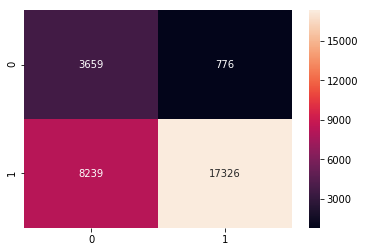

In [86]:
from sklearn.svm import SVC
clf = SVC(max_iter = 800)
clf.fit(bow_X_train, SVM_y_train)
SVM_y_pred=clf.predict(bow_X_test)
print('accuracy_score =', accuracy_score(SVM_y_test, SVM_y_pred))
print('precision_score =', precision_score(SVM_y_test, SVM_y_pred))
print('recall_score =', recall_score(SVM_y_test, SVM_y_pred))
cm = confusion_matrix(SVM_y_test, SVM_y_pred)
sns.heatmap(cm, annot=True, fmt="d")

# RESULTS

In [88]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["MODEL", "Alpha & PENALTY", "ACCURACY", "PRECISION", "RECALL" ]
#BOW
x.add_row(['BOW with SVM GridSearch', '5 & L2', 0.90, 0.90, 0.99])
x.add_row(["BOW with SVM Random", '1 & L1', 0.90, 0.90, 0.99])
x.add_row(['--'*5,'-'*5,'-'*8,'-'*5, '--'*5])
#TFIDF
x.add_row(['TFIDF with SVM GridSearch', '5 & L2', 0.89, 0.89, 0.99])
x.add_row(["TFIDF with SVM Random", '10 & L1' ,0.89, 0.89, 0.99])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5])
#AVGW2V
x.add_row(['AVGW2V with SVM GridSearch', '100 & L2', 0.89, 0.89, 0.98])
x.add_row(["AVGW2V with SVM Random", '10 & L1', 0.88, 0.88, 0.97])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5])
#TFIDFW2V
x.add_row(['TFIDFW2V with SVM GridSearch', '0.000 & L2', 0.87, 0.88, 0.98])
x.add_row(["TFIDFW2V with SVM Random", '0.0001 & L2', 0.87, 0.88, 0.99])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5])
#SVC
x.add_row(['BOW with SVC', 'Default', 0.69, 0.95, 0.67])
print(x)

+------------------------------+-----------------+----------+-----------+------------+
|            MODEL             | Alpha & PENALTY | ACCURACY | PRECISION |   RECALL   |
+------------------------------+-----------------+----------+-----------+------------+
|   BOW with SVM GridSearch    |      5 & L2     |   0.9    |    0.9    |    0.99    |
|     BOW with SVM Random      |      1 & L1     |   0.9    |    0.9    |    0.99    |
|          ----------          |      -----      | -------- |   -----   | ---------- |
|  TFIDF with SVM GridSearch   |      5 & L2     |   0.89   |    0.89   |    0.99    |
|    TFIDF with SVM Random     |     10 & L1     |   0.89   |    0.89   |    0.99    |
|          ----------          |     --------    | -------- |   -----   | ---------- |
|  AVGW2V with SVM GridSearch  |     100 & L2    |   0.89   |    0.89   |    0.98    |
|    AVGW2V with SVM Random    |     10 & L1     |   0.88   |    0.88   |    0.97    |
|          ----------          |     ------

In [60]:
#number of positive and negative values in test data
y_test.value_counts()

1    90894
0    18358
Name: Score, dtype: int64

**OBSERVATIONS**

since AVGW2v and TFIDFW2V took too much time for converting to a vector. the total number of datapoints used are limited to 100K. also, the BOW & TFIDF were trained on all data and the confusion matrix and accuracy score were same in percentages.


1. The best results were obtained from BOW with closely 10.7k mis-classifications out of 100k datapoints.


2. SVM lags behind Logistic Regression Model. the maximum misclassification in logistic regression was 2.5k. but this exceeds to atleast 3k misclassification in all models. 


3. The original SVM classifer in SKlearn is trained on our best model with default values and the best values we get is less than what we achieved in SGDClassifier with hinge loss.


4. SVM gave 10k misclassification out of 100k points than SGD which showed 3k misclassification. so it is good to use SGD with Hingeloss which is fast and also can operate on whole data.


5. the precision and recall were high on almost all the models.


6. Till now the best model on amazon fine food reviews is Logistic Regression it has accuracy of 92 and misclassification of 2.3K reviews.


7. since this data is imbalanced, there are large amount of data for positive reviews. so, the False positive rate is very high on almost all the vectorizers. W2V perfom very bad on this.